# House Plant classification using ResNet-34

In [1]:
import os
import zipfile
import shutil
import random
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from typing import Dict, List
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD
from torch.optim.optimizer import Optimizer
from torch.nn import CrossEntropyLoss
from torch import nn


# 0. Install and Import libs

In [2]:
!pip install torchmetrics

In [3]:
! pip install torchsummary

In [4]:
from torchsummary import summary
import torchmetrics

# 1. Exploring the data and create dataset objects

## 1.1 Getting the data



In [5]:
data_path = '/kaggle/working/data'
original_path = '/kaggle/working/house_plant_species'

In [6]:
!kaggle datasets download -d kacpergregorowicz/house-plant-species

Dataset URL: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species
License(s): CC-BY-NC-SA-4.0
100%|██████████████████████████████████████▉| 4.84G/4.85G [00:41<00:00, 145MB/s]
100%|███████████████████████████████████████| 4.85G/4.85G [00:41<00:00, 126MB/s]


In [7]:
# Extract dataset
with zipfile.ZipFile('/kaggle/working/house-plant-species.zip', 'r') as file_zip:
    file_zip.extractall()

## 1.2 Exploration

In [8]:
def show_random_species(original_path: str ) -> None:
  plt.figure(figsize=(12, 12))
  for i in range(9):
    specie = random.sample(os.listdir(original_path), k=1)[0]
    image_path = random.sample(os.listdir(f'{original_path}/{specie}'), k=1)[0]

    plt.subplot(3, 3, i+1)
    image = plt.imread(f'{original_path}/{specie}/{image_path}')
    plt.title(specie)
    plt.axis(False)
    plt.imshow(image)

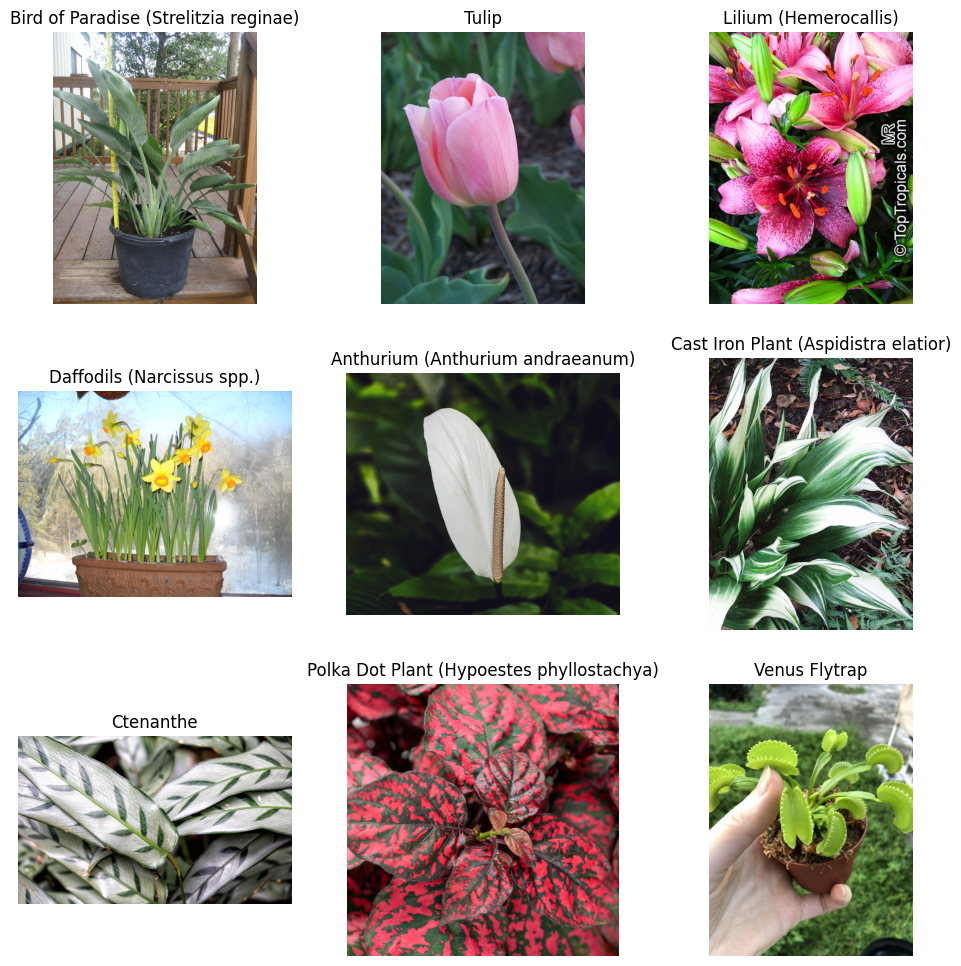

In [9]:
show_random_species(original_path)

In [10]:
species_df = pd.DataFrame(columns=['species', 'qty'])
species_df['species'] = os.listdir(original_path)
species_df['qty'] = [len(os.listdir(f"{original_path}/{specie}")) for specie in os.listdir(original_path)]

In [11]:
species_df[:10]

,species,qty
0,Lily of the valley (Convallaria majalis),416
1,Birds Nest Fern (Asplenium nidus),290
2,Chinese Money Plant (Pilea peperomioides),382
3,Lilium (Hemerocallis),480
4,Chinese evergreen (Aglaonema),514
5,Parlor Palm (Chamaedorea elegans),329
6,Hyacinth (Hyacinthus orientalis),318
7,Rattlesnake Plant (Calathea lancifolia),316
8,Iron Cross begonia (Begonia masoniana),266
9,Snake plant (Sanseviera),396


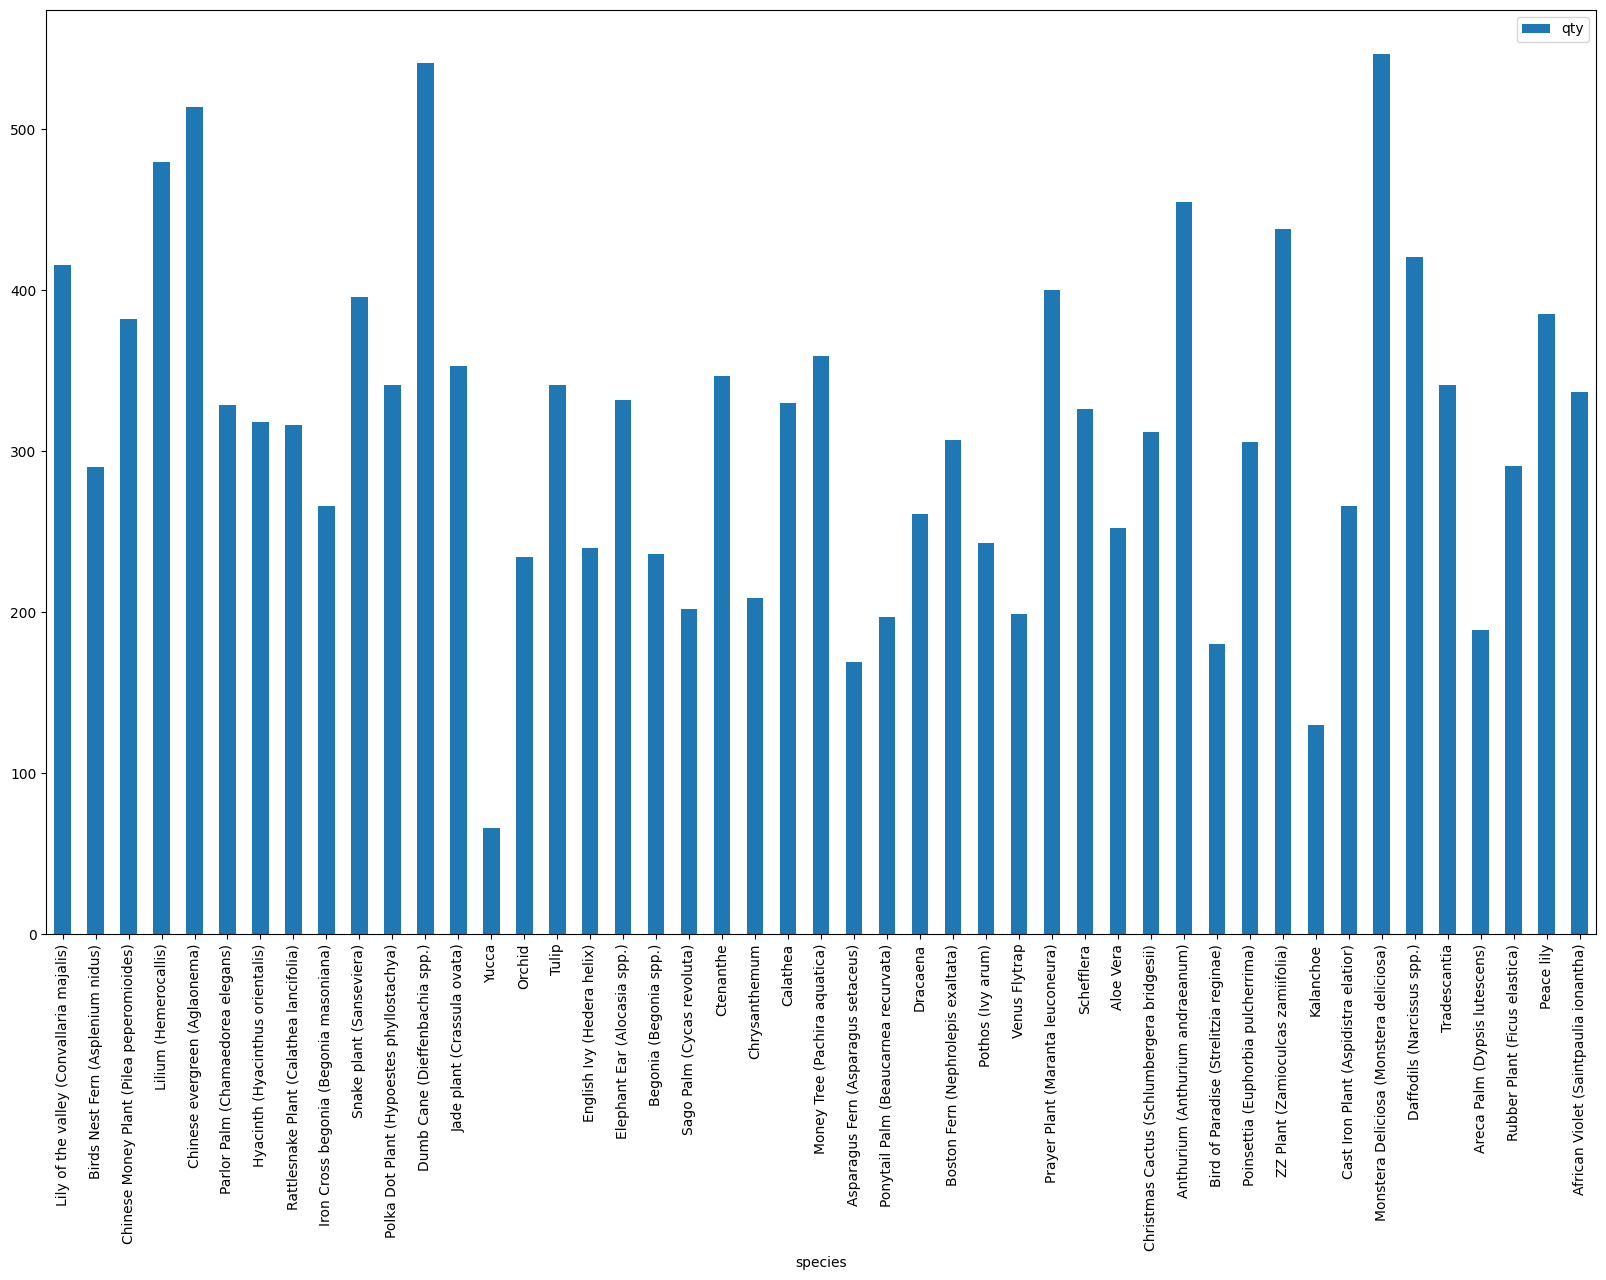

In [12]:
species_df.plot(kind='bar', x='species', y='qty', figsize=(20, 12));

## 1.3 Formating folder structures to standart classification format
- /imagens
    - /train
      - /class1
      - /class2
      - /...
    - /validation
      - /class1
      - /class2
      - /...
    - /test
      - /class1
      - /class2
      - /...


Sampling will be done using python random.samples

In [13]:
# Returns a simple version of specie name
def get_specie_name(specie: str) -> str:
  specie_name = specie.split('(')[0].lower().replace(' ', '_')
  return specie_name[:len(specie_name)-1] if specie_name[-1] == '_' else specie_name


def create_dataset_folders(new_path: str, original_path: str) -> None:
  species = os.listdir(original_path)

  # General folders
  os.makedirs(f'{new_path}/train', exist_ok=True)
  os.makedirs(f'{new_path}/test', exist_ok=True)

  # Create folders for each specie
  for dataset in os.listdir(new_path):
      for specie in species:
        os.makedirs(f'{new_path}/{dataset}/{get_specie_name(specie)}', exist_ok=True)

# Random sampling for each catgory and retunrna dict with classes as key
# and test images as value
def get_test_images(path: str, test_size: float) -> Dict[str, str]:
  test_images = {}
  for specie in os.listdir(path):
    qty = len(os.listdir(f'{path}/{specie}'))
    test_qty = int(qty * test_size)
    print(f'{specie}: {qty}, {test_qty}')
    test_samples = random.sample(os.listdir(f'{path}/{specie}'), test_qty)
    test_images[specie] = test_samples

  return test_images

# Move test and train images to respective folders
def move_images(test_images: dict, original_path: str, new_path: str) -> None:

  # Move images test to test folder
  for specie, images in test_images.items():
    for image in images:
      shutil.copy(f'{original_path}/{specie}/{image}', f'{new_path}/test/{get_specie_name(specie)}')

  # Move the rest os images to train folder
  for specie in os.listdir(original_path):
    for image in os.listdir(f'{original_path}/{specie}'):
      shutil.copy(f'{original_path}/{specie}/{image}', f'{new_path}/train/{get_specie_name(specie)}')



In [14]:
create_dataset_folders(new_path=data_path, original_path=original_path)

test_images = get_test_images(path=original_path, test_size=0.2)

move_images(test_images=test_images,
            original_path=original_path,
            new_path=data_path)



Lily of the valley (Convallaria majalis): 416, 83
Birds Nest Fern (Asplenium nidus): 290, 58
Chinese Money Plant (Pilea peperomioides): 382, 76
Lilium (Hemerocallis): 480, 96
Chinese evergreen (Aglaonema): 514, 102
Parlor Palm (Chamaedorea elegans): 329, 65
Hyacinth (Hyacinthus orientalis): 318, 63
Rattlesnake Plant (Calathea lancifolia): 316, 63
Iron Cross begonia (Begonia masoniana): 266, 53
Snake plant (Sanseviera): 396, 79
Polka Dot Plant (Hypoestes phyllostachya): 341, 68
Dumb Cane (Dieffenbachia spp.): 541, 108
Jade plant (Crassula ovata): 353, 70
Yucca: 66, 13
Orchid: 234, 46
Tulip: 341, 68
English Ivy (Hedera helix): 240, 48
Elephant Ear (Alocasia spp.): 332, 66
Begonia (Begonia spp.): 236, 47
Sago Palm (Cycas revoluta): 202, 40
Ctenanthe: 347, 69
Chrysanthemum: 209, 41
Calathea: 330, 66
Money Tree (Pachira aquatica): 359, 71
Asparagus Fern (Asparagus setaceus): 169, 33
Ponytail Palm (Beaucarnea recurvata): 197, 39
Dracaena: 261, 52
Boston Fern (Nephrolepis exaltata): 307, 61
P

## 1.4 Dataset objects

In [15]:
# Set the project seed
torch.manual_seed(42)

# Transforms the images with some data augmentation on train data
train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomVerticalFlip(0.5),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomRotation(0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Basic transforms on the test data
test_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

> 🔔 [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#imagefolder)

Folders structure
- root/dog/xxx.png
- root/dog/xxy.png
- root/dog/[...]/xxz.png
---
- root/cat/123.png
- root/cat/nsdf3.png
- root/cat/[...]/asd932_.png

In [16]:
train_dataset = ImageFolder(root=f'{data_path}/train',
                            transform=train_transformer)

test_dataset = ImageFolder(root=f'{data_path}/test',
                           transform=test_transformer)

In [17]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 14774
     Root location: /kaggle/working/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomVerticalFlip(p=0.5)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-0.5, 0.5], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 2940
     Root location: /kaggle/working/data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [18]:
test_dataset.class_to_idx

{'african_violet': 0,
 'aloe_vera': 1,
 'anthurium': 2,
 'areca_palm': 3,
 'asparagus_fern': 4,
 'begonia': 5,
 'bird_of_paradise': 6,
 'birds_nest_fern': 7,
 'boston_fern': 8,
 'calathea': 9,
 'cast_iron_plant': 10,
 'chinese_evergreen': 11,
 'chinese_money_plant': 12,
 'christmas_cactus': 13,
 'chrysanthemum': 14,
 'ctenanthe': 15,
 'daffodils': 16,
 'dracaena': 17,
 'dumb_cane': 18,
 'elephant_ear': 19,
 'english_ivy': 20,
 'hyacinth': 21,
 'iron_cross_begonia': 22,
 'jade_plant': 23,
 'kalanchoe': 24,
 'lilium': 25,
 'lily_of_the_valley': 26,
 'money_tree': 27,
 'monstera_deliciosa': 28,
 'orchid': 29,
 'parlor_palm': 30,
 'peace_lily': 31,
 'poinsettia': 32,
 'polka_dot_plant': 33,
 'ponytail_palm': 34,
 'pothos': 35,
 'prayer_plant': 36,
 'rattlesnake_plant': 37,
 'rubber_plant': 38,
 'sago_palm': 39,
 'schefflera': 40,
 'snake_plant': 41,
 'tradescantia': 42,
 'tulip': 43,
 'venus_flytrap': 44,
 'yucca': 45,
 'zz_plant': 46}

In [19]:
# (image, categorie)
train_dataset[0][0].shape, train_dataset[0][0].dtype, train_dataset[0]

(torch.Size([3, 224, 224]),
 torch.float32,
 (tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1179],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1179],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1179],
           ...,
           [-2.1179,  1.9407,  1.8722,  ...,  1.7180,  1.7865,  1.5982],
           [-2.1179,  1.8550,  1.9407,  ...,  1.5297,  1.5468,  1.3413],
           [-2.1179,  1.8379,  1.9407,  ..., -2.1179, -2.1179, -2.1179]],
  
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0357],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0357],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0357],
           ...,
           [-2.0357,  2.0784,  1.9909,  ...,  1.8683,  1.9384,  1.7283],
           [-2.0357,  1.9909,  2.0434,  ...,  1.6758,  1.6933,  1.4482],
           [-2.0357,  1.9209,  2.0609,  ..., -2.0357, -2.0357, -2.0357]],
  
          [[-1.8044, -1.8044, -1.8044,  

## 1.5 Data Loaders

> 🔔 **Differences between Dataset classes and DataLoaders**:

In [20]:
# Convert ImageFolder objects in to DataLoaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=128,
                              num_workers=2,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             num_workers=2,
                             batch_size=128,
                             shuffle=False)

## 1.6 Set Device


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device} device')

Using cuda device


# 2. ResNet34 import vs ResNet34 from scratch

> Paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)

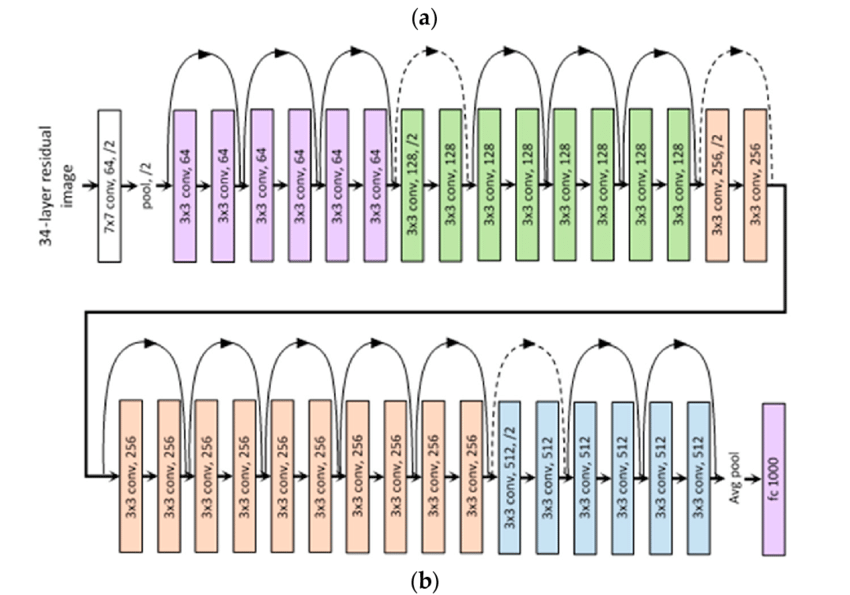

## 2.1 Import Resnet34

In [22]:
imported_resnet34 = models.resnet34(weights=None)

In [23]:
summary(imported_resnet34.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 2.2 ResNet34 from scratch



### 2.3 Residual Blocks

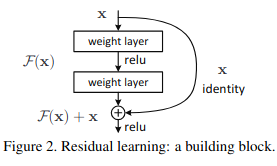 | 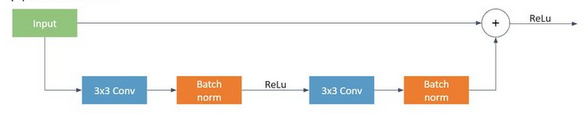

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, stride=1, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Using padding to identity mapping
        if stride == 1:
          self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_features, out_features, kernel_size=3, stride=stride, padding='same', bias=False),
              nn.BatchNorm2d(out_features),
              nn.ReLU()
          )
        else: # stride with no padding when necessary
          self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, stride=stride, bias=False),
              nn.BatchNorm2d(out_features),
              nn.ReLU()
          )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(out_features, out_features, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_features),
        )

        # Using 1x1 convolution to project shotcuts when shapes are mismatching
        self.projection = None
        if stride != 1 or in_features != out_features:
            self.projection = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_features)
            )


    def forward(self, x):
        result = self.conv_block1(x)
        # print(x.shape, result.shape)

        result = self.conv_block2(result)

        # Apply projection shortcut if dimensions mismatch
        if self.projection is not None:
            x = self.projection(x)

        # print(x.shape, result.shape)

        result += x
        result = torch.nn.functional.relu(result)
        return result

>

> 🔔 **Plain Network.** Our plain baselines (Fig. 3, middle) are
mainly inspired by the philosophy of VGG nets [41] (Fig. 3,
left). The convolutional layers mostly have **3×3 filters** and
follow two simple design rules: **(i) for the same output
feature map size, the layers have the same number of filters; and (ii) if the feature map size is halved, the number of filters is doubled so as to preserve the time complexity per layer**. We perform downsampling directly by
convolutional layers that have a stride of 2. The network
ends with a global average pooling layer and a 1000-way
fully-connected layer with softmax. The total number of
weighted layers is 34 in Fig. 3 (middle).

>🔔 **Residual Network**. Based on the above plain network, we
insert shortcut connections (Fig. 3, right) which turn the
network into its counterpart residual version. The identity
shortcuts (Eqn.(1)) can be directly used when the input and
output are of the same dimensions (solid line shortcuts in
Fig. 3). **When the dimensions increase (dotted line shortcuts
in Fig. 3), we consider two options: (A) The shortcut still
performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra
parameter; (B) The projection shortcut in Eqn.(2) is used to
match dimensions (done by 1×1 convolutions). For both
options, when the shortcuts go across feature maps of two
sizes, they are performed with a stride of 2**

>🔔 We adopt batch
normalization (BN) [16] right after each convolution and
before activation, following [16].

In [25]:
class ResNet34(nn.Module):
  def __init__(self,  categories_num=47, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.categories_num = categories_num

    # First conv block + MaxPool
    self.conv_block1 = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
           nn.BatchNorm2d(64),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    blocks = {
        "64": 3,
        "128": 4,
        "256": 6,
        "512": 3
    }

    # Adding residual blocks
    self.residual_blocks = nn.Sequential()
    for n_filters, num_block in blocks.items():
      for block in range(num_block):
        # Every time filter's size change we got stride 2 in the first conv of residual block
        if block == 0 and int(n_filters) > 64:
          self.residual_blocks.append(ResidualBlock(
              in_features=int(n_filters)//2,
              out_features=int(n_filters),
              stride=2,
          ))
        else:
          self.residual_blocks.append(ResidualBlock(
              in_features=int(n_filters),
              out_features=int(n_filters)
          ))

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, 1000)
    self.out = nn.Linear(1000, self.categories_num)


  def forward(self, x):
    # print(x.shape)
    result = self.conv_block1(x)
    # print(result.shape)

    # Pass through all residual blocks
    result = self.residual_blocks(result)
    # print(result.shape)

    result = self.avg_pool(result)
    # print(result.shape)

    result = torch.flatten(result, 1)
    # print(result.shape)

    result = self.fc(result)

    result = self.out(result)

    return result

In [26]:
model = ResNet34()
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
    ResidualBlock-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

# 3. Training the model


In [27]:
def train_step(model: nn.Module,
               loss_fn: nn.CrossEntropyLoss,
               optimizer: Optimizer,
               train_dataset: DataLoader,
               test_dataset: DataLoader,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device) -> Dict[str, float]:

  # Send the model to train model and send to right device
  model= model.to(device)
  model.train()

  total_loss = 0
  total_accuracy =0
  for batch, (X, y) in enumerate(train_dataset):        
    # Send data to available device
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    logits = model(X)

    # Loss
    loss = loss_fn(logits, y)
    total_loss += loss.item()

    # Accuracy
    total_accuracy += accuracy_fn(torch.softmax(input=logits, dim=1).argmax(dim=1), y).to('cpu')

    # Resets the gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Step the optimizer
    optimizer.step()

  return {'loss': total_loss/len(train_dataset), 'accuracy': total_accuracy/len(train_dataset)}

In [28]:
def test_step(model: nn.Module,
              loss_fn: nn.CrossEntropyLoss,
              train_dataset: DataLoader,
              test_dataset: DataLoader,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device) -> Dict[str, float]:

  model = model.to(device)
  model.eval()

  total_loss = 0
  total_accuracy = 0

  for batch, (X, y) in enumerate(test_dataset):
    # Send data to available device
    X = X.to(device)
    y = y.to(device)

    with torch.inference_mode():
      # Forward pass
      logits = model(X)

      # Loss
      loss = loss_fn(logits, y)
      total_loss += loss.item()

      total_accuracy += accuracy_fn(torch.softmax(input=logits, dim=1).argmax(dim=1), y).to('cpu')


  return {'loss': total_loss/len(test_dataset), 'accuracy': total_accuracy/len(test_dataset)}

> 🔔

In [29]:
def train(epochs: int,
          model: nn.Module,
          loss_fn: nn.CrossEntropyLoss,
          optimizer: Optimizer,
          train_dataset: DataLoader,
          test_dataset: DataLoader,
          accuracy_fn: torchmetrics.Accuracy,
          device: torch.device) -> Dict[str, List[float]]:

  history = {
      'train_loss': [],
      'test_loss': [],
      'train_accuracy': [],
      'test_accuracy': [],
  }

  best_test_acc = 0

  # Performes train and test step for each epoch
  for epoch in range(epochs):
    history_train_step = train_step(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        accuracy_fn=accuracy_fn,
        device=device
    )

    history_test_step = test_step(
        model=model,
        loss_fn=loss_fn,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        accuracy_fn=accuracy_fn,
        device=device
    )

    print("-"*50)
    print(f'Epoch: {epoch+1} \nTrain loss: {history_train_step["loss"]} | Test loss: {history_test_step["loss"]} \nTrain accuracy: {history_train_step["accuracy"]} | Test accuracy: {history_test_step["accuracy"]}')
      
    if history_test_step['accuracy'] > best_test_acc:
        print("Saving the best model, accuracy: ", history_test_step['accuracy'].item())        
        best_test_acc = history_test_step['accuracy']
        torch.save(model.state_dict(), 'best_model.pt')

    print("-"*50)

    history['train_loss'].append(history_train_step['loss'])
    history['test_loss'].append(history_test_step['loss'])
    history['train_accuracy'].append(history_train_step['accuracy'])
    history['test_accuracy'].append(history_test_step['accuracy'])

  return history

## Train model

In [30]:
NUM_CLASSES = 47

In [31]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

history = train(model=model,
                loss_fn=nn.CrossEntropyLoss(),
                optimizer=SGD(model.parameters(), lr=0.01),
                epochs=30,
                train_dataset=train_dataloader,
                test_dataset=test_dataloader,
                accuracy_fn=accuracy_fn,
                device=device)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 1 
Train loss: 3.4749561260486472 | Test loss: 3.7660840594250224 
Train accuracy: 0.09843700379133224 | Test accuracy: 0.08763586729764938
Saving the best model, accuracy:  0.08763586729764938
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 2 
Train loss: 3.03809811740086 | Test loss: 3.537626836610877 
Train accuracy: 0.18630018830299377 | Test accuracy: 0.13493819534778595
Saving the best model, accuracy:  0.13493819534778595
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 3 
Train loss: 2.7661152235392867 | Test loss: 3.4395696598550547 
Train accuracy: 0.24816909432411194 | Test accuracy: 0.16312018036842346
Saving the best model, accuracy:  0.16312018036842346
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 4 
Train loss: 2.5610616330442757 | Test loss: 3.3407822484555454 
Train accuracy: 0.29026979207992554 | Test accuracy: 0.19621098041534424
Saving the best model, accuracy:  0.19621098041534424
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 5 
Train loss: 2.372611604887864 | Test loss: 2.8337142260178276 
Train accuracy: 0.3385491669178009 | Test accuracy: 0.24504734575748444
Saving the best model, accuracy:  0.24504734575748444
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 6 
Train loss: 2.2196038468130705 | Test loss: 3.304320278375045 
Train accuracy: 0.3745060861110687 | Test accuracy: 0.23701567947864532
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 7 
Train loss: 2.0665755261634957 | Test loss: 2.966160069341245 
Train accuracy: 0.4145364463329315 | Test accuracy: 0.26021212339401245
Saving the best model, accuracy:  0.26021212339401245
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 8 
Train loss: 1.9293876269768024 | Test loss: 2.397614712300508 
Train accuracy: 0.44378092885017395 | Test accuracy: 0.3267443776130676
Saving the best model, accuracy:  0.3267443776130676
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 9 
Train loss: 1.7942258057923153 | Test loss: 3.2619680321734883 
Train accuracy: 0.4803240895271301 | Test accuracy: 0.22727473080158234
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 10 
Train loss: 1.679235474816684 | Test loss: 2.6532534671866377 
Train accuracy: 0.512005627155304 | Test accuracy: 0.3213205635547638
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 11 
Train loss: 1.585600648460717 | Test loss: 2.6761316475660903 
Train accuracy: 0.5383366346359253 | Test accuracy: 0.32627323269844055
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 12 
Train loss: 1.5008532538496215 | Test loss: 2.1607636498368303 
Train accuracy: 0.5595266222953796 | Test accuracy: 0.3949311673641205
Saving the best model, accuracy:  0.3949311673641205
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 13 
Train loss: 1.4020525545909488 | Test loss: 3.266966050085814 
Train accuracy: 0.5843186378479004 | Test accuracy: 0.303536981344223
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 14 
Train loss: 1.3261395610612015 | Test loss: 2.2618387704310208 
Train accuracy: 0.6051394939422607 | Test accuracy: 0.40298473834991455
Saving the best model, accuracy:  0.40298473834991455
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 15 
Train loss: 1.2460128079200614 | Test loss: 1.9507259882014731 
Train accuracy: 0.6249301433563232 | Test accuracy: 0.4756968915462494
Saving the best model, accuracy:  0.4756968915462494
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 16 
Train loss: 1.191765447115076 | Test loss: 1.8108097470324973 
Train accuracy: 0.6433762907981873 | Test accuracy: 0.4884510934352875
Saving the best model, accuracy:  0.4884510934352875
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 17 
Train loss: 1.1124906478257015 | Test loss: 1.6961042751436648 
Train accuracy: 0.6646237373352051 | Test accuracy: 0.5085466504096985
Saving the best model, accuracy:  0.5085466504096985
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 18 
Train loss: 1.0608832039709748 | Test loss: 1.7007463807645051 
Train accuracy: 0.6770159602165222 | Test accuracy: 0.5103655457496643
Saving the best model, accuracy:  0.5103655457496643
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 19 
Train loss: 0.9981609418474394 | Test loss: 2.4679876825083857 
Train accuracy: 0.695848822593689 | Test accuracy: 0.3916878402233124
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 20 
Train loss: 0.9430623373080944 | Test loss: 2.6404252726098765 
Train accuracy: 0.7142001986503601 | Test accuracy: 0.38845548033714294
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 21 
Train loss: 0.9110027037817856 | Test loss: 1.868925208630769 
Train accuracy: 0.7171735167503357 | Test accuracy: 0.49002891778945923
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 22 
Train loss: 0.8625783283134987 | Test loss: 2.5466511042221733 
Train accuracy: 0.7335293889045715 | Test accuracy: 0.40576788783073425
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 23 
Train loss: 0.8154680518240764 | Test loss: 3.1650205902431323 
Train accuracy: 0.7477076053619385 | Test accuracy: 0.35002848505973816
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 24 
Train loss: 0.7687701269470412 | Test loss: 1.9418278077374334 
Train accuracy: 0.7611674666404724 | Test accuracy: 0.5447164177894592
Saving the best model, accuracy:  0.5447164177894592
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 25 
Train loss: 0.7409423168363243 | Test loss: 1.4338172155877817 
Train accuracy: 0.7687429785728455 | Test accuracy: 0.5851705074310303
Saving the best model, accuracy:  0.5851705074310303
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 26 
Train loss: 0.6866535770482031 | Test loss: 1.3866310897080794 
Train accuracy: 0.7877529263496399 | Test accuracy: 0.6132867336273193
Saving the best model, accuracy:  0.6132867336273193
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 27 
Train loss: 0.6408371827725706 | Test loss: 1.8532086844029634 
Train accuracy: 0.801886260509491 | Test accuracy: 0.5558489561080933
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 28 
Train loss: 0.6222991491186207 | Test loss: 1.4581859889237776 
Train accuracy: 0.802814245223999 | Test accuracy: 0.5993929505348206
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 29 
Train loss: 0.5822248114594097 | Test loss: 2.147551098595495 
Train accuracy: 0.8154508471488953 | Test accuracy: 0.4937762916088104
--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


--------------------------------------------------
Epoch: 30 
Train loss: 0.5557587133913204 | Test loss: 2.2876463895258694 
Train accuracy: 0.8261668682098389 | Test accuracy: 0.45804479718208313
--------------------------------------------------


## Visualizing metrics curves

In [32]:
def plot_metrics(history: Dict[str, List[float]]) -> None:
  epochs = len(history['train_loss'])

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs+1), history['train_loss'])
  plt.plot(range(1, epochs+1), history['test_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'])

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs+1), history['train_accuracy'])
  plt.plot(range(1, epochs+1), history['test_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'])

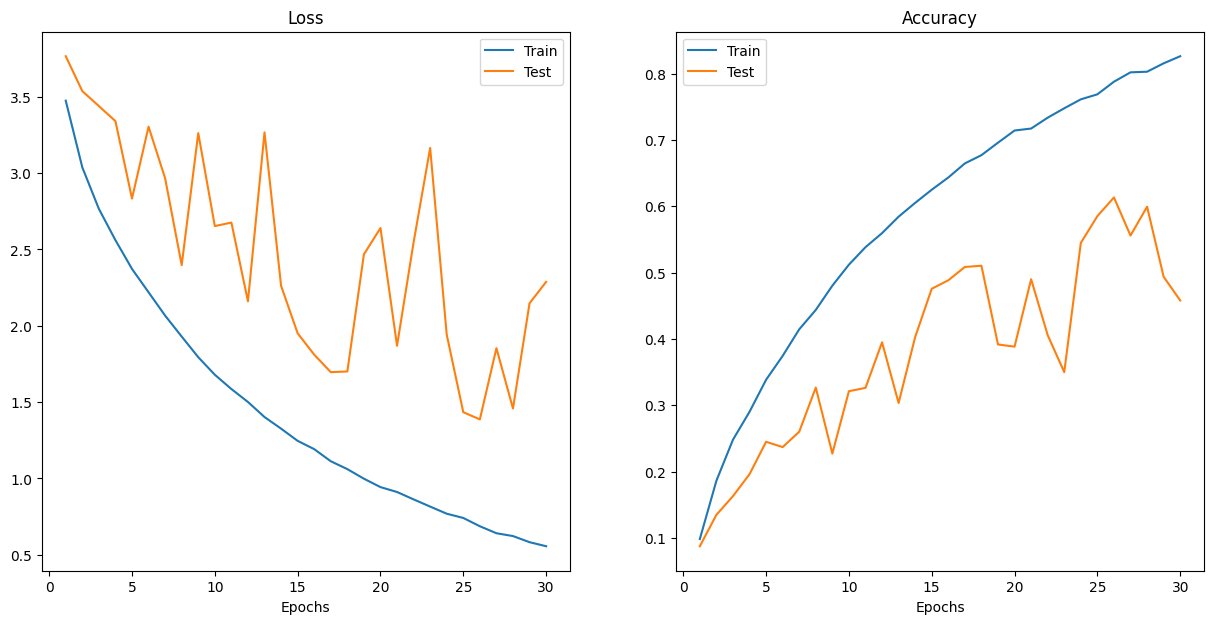

In [33]:
plot_metrics(history=history)

### Loading model

In [34]:
loaded_model = ResNet34()
loaded_model.load_state_dict(torch.load('/kaggle/working/best_model.pt', weights_only=True))
loaded_model.eval()

ResNet34(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_block2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
       

In [35]:
#torch.save(model, '/kaggle/working/model.pt')
#load_model = torch.load('/kaggle/working/model.pt')

In [36]:
def show_random_species_predict(original_path: str ) -> None:
  batch = []
  images = []
  species = []

  # Open images and create batch
  for i in range(9):
    specie = random.sample(os.listdir(original_path), k=1)[0]
    species.append(specie)
      
    image_path = random.sample(os.listdir(f'{original_path}/{specie}'), k=1)[0]
    image = Image.open(f'{original_path}/{specie}/{image_path}')
    images.append(image)
      
    # Transform image
    transformed_image = test_transformer(image) 

    batch.append(transformed_image)

      
  # Predict
  batch = torch.stack(batch)
  logits = loaded_model(batch)
  cls = torch.softmax(input=logits, dim=1).argmax(dim=1)

  plt.figure(figsize=(18, 12))    
  for i, (image, specie, clas) in enumerate(zip(images, species, cls)):
    plt.subplot(3, 3, i+1)
      
    plt.title(f"Specie: {specie} \n predict: {test_dataset.classes[clas.item()]}")
    plt.axis(False)
    plt.imshow(image)

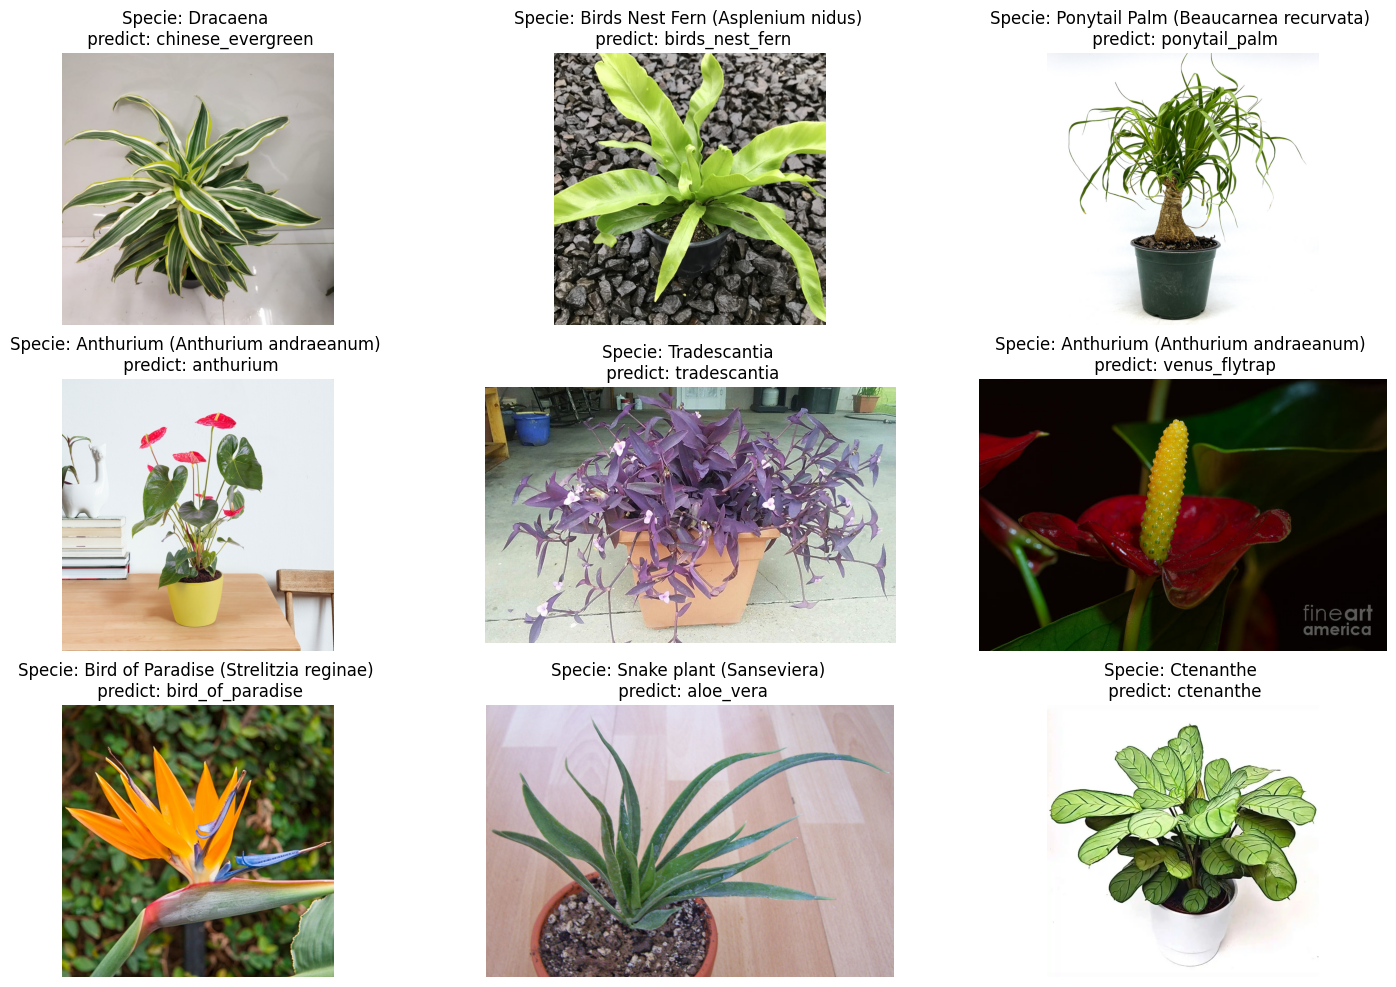

In [37]:
show_random_species_predict(original_path)